In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

2023-02-02 00:17:43.361960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 00:17:43.454514: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-02 00:17:43.999185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-02 00:17:43.999230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
path = './Data/'
train_path = path + 'train_datasets/'
valid_path = path + 'valid_datasets/'

In [3]:
IMG_SHAPE = (224, 224)

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_dataset = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMG_SHAPE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_dataset = valid_datagen.flow_from_directory(valid_path,
                                            target_size = IMG_SHAPE,
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 9850 images belonging to 10 classes.
Found 1710 images belonging to 10 classes.


In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE + (3,),
                                               include_top=False,
                                               weights='imagenet')

2023-02-02 00:17:45.024317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 00:17:45.049312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-02 00:17:45.049332: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-02 00:17:45.049989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [6]:
base_model.trainable = False

In [7]:
x = tf.keras.layers.Flatten()(base_model.output)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


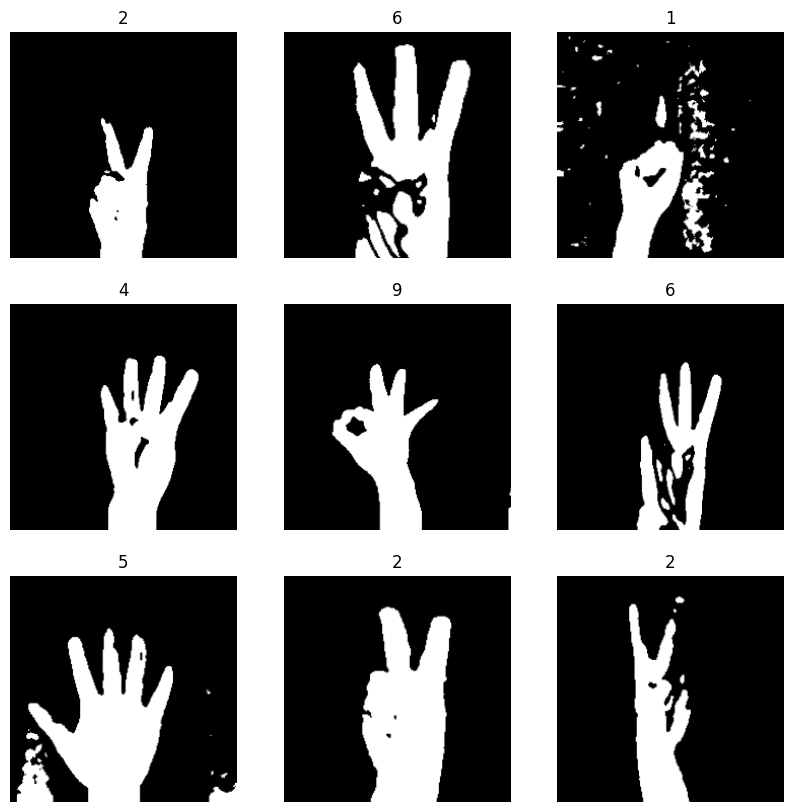

In [9]:
class_names = list(train_dataset.class_indices.keys())
print(class_names)
plt.figure(figsize=(10, 10))
images, labels = train_dataset[0]

print(labels[:10])
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(class_names[np.argmax(labels[i])])
  plt.axis("off")

In [10]:
history = model.fit(train_dataset,
                    epochs= 3,
                    validation_data=valid_dataset)

Epoch 1/3
308/308 [==============================] - 124s 397ms/step - loss: 0.1998 - accuracy: 0.9470 - val_loss: 1.6588 - val_accuracy: 0.5357
Epoch 2/3
308/308 [==============================] - 121s 394ms/step - loss: 0.0234 - accuracy: 0.9951 - val_loss: 1.7736 - val_accuracy: 0.5778
Epoch 3/3
308/308 [==============================] - 123s 400ms/step - loss: 0.0207 - accuracy: 0.9964 - val_loss: 1.4660 - val_accuracy: 0.5819


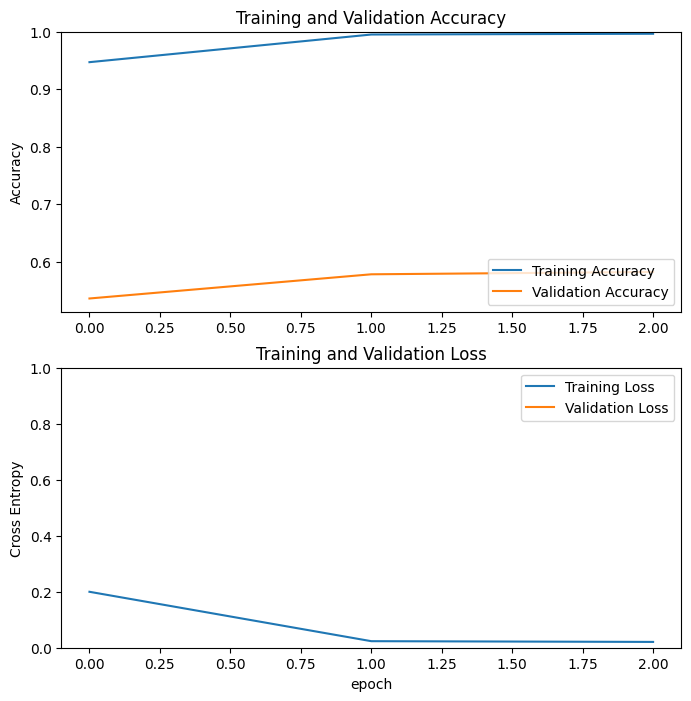

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
model.save('hand_gesture.h5')